<a href="https://colab.research.google.com/github/thangyou123/Mathematical-Modeling-project/blob/main/Cau4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import scipy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def process_df(path, label, country_list):
  """
  Read data from a .csv file\n
  :param path: CSV file path\n
  :param label: Data label\n
  :param country_list: List of countries to retrieve data\n
  :return: Dataframe with associated data
  """
  df = pd.read_csv(path)
  df.set_index("Country/Region", inplace=True)
  df.index.name = "Date"
  df = df.loc[country_list]
  df.drop(df.columns[:3], axis=1, inplace=True)
  df = df.T
  df[label] = df.sum(axis=1, skipna=True, numeric_only=True)
  df = df[[label]]
  return df

def process_data(country_list, population):
  """
  Load Covid-19 data from some countries.\n
  :param country_list: List of countries to retrieve data\n
  :param population: Total population of countries in [country_list]\n
  :return: Covid-19 dataset
  """
  recovered_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
  death_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
  confirmed_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

  recovered_df = process_df(recovered_url, "removed", country_list)
  death_df = process_df(death_url, "removed", country_list)
  removed_df = recovered_df.add(death_df, fill_value=0)
  confirmed_df = process_df(confirmed_url, "confirmed", country_list)
  covid_df = removed_df.merge(confirmed_df, left_index=True, right_index=True)
  covid_df['infected'] = covid_df['confirmed'] - covid_df['removed']
  covid_df.drop(['confirmed'], axis=1, inplace=True)
  covid_df['suscepted'] = population - covid_df['removed'] - covid_df['infected']
  return covid_df

In [ ]:
# Log of probability density function for poisson distribution
def log_poisson(mu):
  return np.log(mu)-mu

# Log of probability density function for beta distribution
def beta_logpdf(x):
    return beta_dist.logpdf(x)

# Log of probability density function for gamma distribution
def gamma_logpdf(x):
    return gamma_dist.logpdf(x)

# Log of probability density function for prior distribution
def log_prior(x):
    if x[0] <= 0 or x[1] <= 0:
        return -np.inf
    return beta_logpdf(x[0]) + gamma_logpdf(x[1])

# Log of likelihood function
def log_likelihood(x, data):
    """
    :param x: parameters, respectively [beta, gamma]
    :param data: Array like, include total infected and removed cases
    :return: Return log of probability evaluated how likely is data for a given x
    """

    if x[0] <= 0 or x[1] <= 0:
        return -np.inf
    size = data.shape[0]
    S = np.zeros(size)
    I = np.zeros(size)
    R = np.zeros(size)

    I[0], R[0] = data[0]
    S[0] = N - I[0] - R[0]

    # Use SIR model and Euler method to estimate total infected and removed cases from real data
    for i in range(size - 1):
        I[i + 1] = data[i, 0] + x[0] * data[i, 0] * S[i] / N - x[1] * data[i, 0]
        R[i + 1] = data[i, 1] + x[1] * data[i, 0]
        S[i + 1] = N - data[i + 1, 0] - data[i + 1, 1]

    # Calculate differences between estimated data and real data to ensure that
    # statistical model sticks with system dynamic model
    res = -np.sum(np.log(np.square((data[:, 0] - I) / (data[:, 0] + 1)) + 1)) - np.sum(
        np.log(np.square((data[:, 1] - R) / (data[:, 1] + 1)) + 1))
    
    return res

#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0,1)
        return accept <= (np.exp(x_new-x))

def metropolis_hastings(likelihood_computer, prior, transition_model, param_init, iterations, data, acceptance_rule, burn_in=0):
    """
    Draw samples from the posterior using Metropolis-Hastings method.\n
    :param likelihood_computer(x, data): returns the likelihood that these parameters generated the data\n
    :param prior: prior distribution for parameters\n
    :param transition_model(x): a function that draws a sample from a symmetric distribution and returns it\n
    :param param_init: a starting sample\n
    :param iterations: number of samples to draw\n
    :param data: the data that we wish to model\n
    :param acceptance_rule(x, x_new): decides whether to accept or reject the new sample\n
    :param burn_in: number of samples to be dropout after generated, default is 0\n
    :return: Return a sample from posterior distribution with size of (iterations-burn_in)
    """
    
    x = param_init
    accepted = []
    rejected = []
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x, data) + prior(x)
        x_new_lik = likelihood_computer(x_new, data) + prior(x_new)
        if (acceptance_rule(x_lik, x_new_lik)):            
            x = x_new
            accepted.append(x_new)
        else:
            accepted.append(x)
            rejected.append(x_new)
                
    return np.array(accepted[burn_in:]), np.array(rejected)

Countries:  ['Singapore', 'Thailand', 'Japan', 'Australia', 'Italy', 'Indonesia', 'Vietnam']
Total Population:  658950685


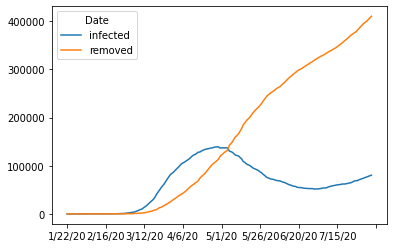

In [ ]:
country_list = ["Singapore", "Thailand", "Japan", "Australia", "Italy", "Indonesia", "Vietnam"]
N = 5_850_342 + 69_799_978 + 126_476_461 + 25_499_884 + 60_461_826 + 273_523_615 + 97_338_579
print("Countries: ", country_list)
print("Total Population: ", N)

covid_df = process_data(country_list, N)
covid_df[['infected', 'removed']].plot()

In [ ]:
# Define prior distribution for beta and gamma
beta_dist = scipy.stats.gamma(a=1, scale=0.5)
gamma_dist = scipy.stats.gamma(a=1, scale=0.3)
# beta_dist = scipy.stats.norm(loc=0, scale=0.1)
# gamma_dist = scipy.stats.norm(loc=0, scale=0.05)

In [ ]:
# Estimate R0 from day [start] to day [end]
# Change start and end value to see more result
start = 0
end = 250
if end > covid_df.shape[0]:
    end = covid_df.shape[0]

# Get total infected and removed cases from Covid dataset
data = np.array(covid_df[['infected', 'removed']])[start:end]

In [ ]:
# Sample from posterior distributions
transition_model = lambda x: np.random.normal(x, [0.01, 0.005], 2)
sample_size = 10000
burn_in = int(0.2*sample_size)
param_init = np.array([0.07, 0.025])

accepted, rejected = metropolis_hastings(log_likelihood, log_prior, transition_model, param_init, sample_size, data, acceptance, burn_in)

In [ ]:
print(rejected.shape)
accepted[-5:]

(1394, 2)


array([[0.13060809, 0.01869157],
       [0.11947667, 0.02204936],
       [0.11840842, 0.01844521],
       [0.12714176, 0.01915131],
       [0.1364832 , 0.02559457]])

In [ ]:
estimate_R0 = accepted[:, 0].sum() / accepted[:, 1].sum()
print("Estimate R0 from day {0} to day {1}: ".format(start, end), estimate_R0)

Estimate R0 from day 0 to day 198:  2.67610241430602


In [ ]:
quantiles = np.quantile(accepted, [0.025, 0.975], axis=0).T
quantile_df = pd.DataFrame(quantiles, index=['\u03B2', '\u03B3'], columns=['2.5%', '97.5%'])
quantile_df

,2.5%,97.5%
β,0.005806,0.170075
γ,0.001908,0.059775


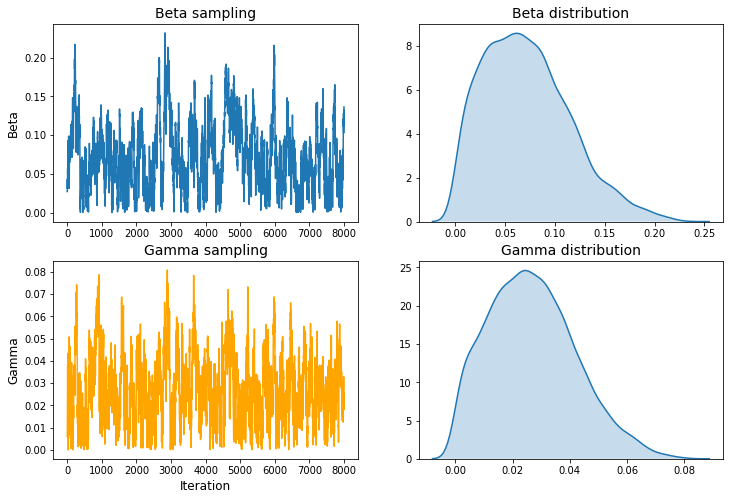

In [ ]:
# Data visualization
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(range(accepted.shape[0]), accepted[:, 0])
plt.ylabel('Beta', fontsize=12)
plt.title('Beta sampling', fontsize=14)

plt.subplot(2, 2, 2)
sns.kdeplot(accepted[:, 0], shade=True)
plt.title('Beta distribution', fontsize=14)

plt.subplot(2, 2, 3)
plt.plot(range(accepted.shape[0]), accepted[:, 1], color='orange')
plt.ylabel('Gamma', fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.title('Gamma sampling', fontsize=14)

plt.subplot(2, 2, 4)
sns.kdeplot(accepted[:, 1], shade=True)
plt.title('Gamma distribution', fontsize=14)
plt.savefig("beta_gamma_posterior.png")

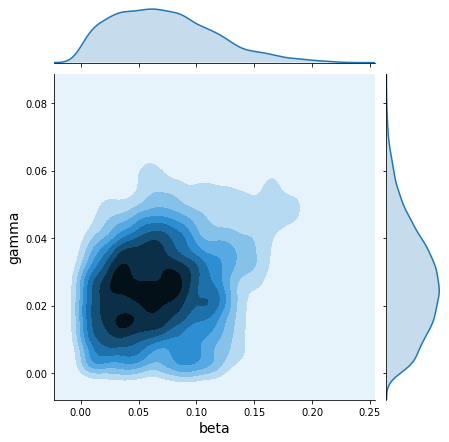

In [ ]:
ax = sns.jointplot(accepted[:, 0], accepted[:, 1], kind='kde')
ax.set_axis_labels("beta", "gamma", fontsize=14)
plt.savefig("beta_gamma_posterior_joint.png")